# Plotting Regularized WGAN vs OTS
**GPU-only implementation.**

In [16]:
import os, sys
sys.path.append("..")

import matplotlib
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline 

import numpy as np
import torch
from torch import nn
import gc

from src.icnn import View
import src.map_benchmark as mbm
from src.unet import UNet
import torch.nn.functional as F
from src.tools import freeze 

from tqdm import tqdm_notebook
from IPython.display import clear_output

## Changable Config

In [2]:
BATCH_SIZE = 64
GPU_DEVICE = 6

GP = 10
LAMBDAS = [0, 0.1, 1, 10, 100, 1000, 10000, 100000]

assert torch.cuda.is_available()
torch.cuda.set_device(GPU_DEVICE)
torch.manual_seed(0x000000); np.random.seed(0x000000)

IN_PATH = '../checkpoints/IPM_vs_OTS'

## Benchmark Loading

In [3]:
benchmark = mbm.CelebA64Benchmark(which='Early', batch_size=BATCH_SIZE)

# Swap output and input
X_sampler = benchmark.output_sampler
Y_sampler = benchmark.input_sampler

## Fixed images for plotting

In [4]:
Y_fixed = Y_sampler.sample(10).requires_grad_(True)
X_fixed = benchmark.output_sampler.potential.push(Y_fixed).detach()
Y_fixed.requires_grad_(False)
pass

## Initializing networks

In [5]:
# Generator
T = nn.Sequential(
    View(3,64,64),
    UNet(n_channels=3, n_classes=3),
    View(64*64*3)
)

In [18]:
def evaluate(size=2**14):
    losses = []
    for i in range(0, size, BATCH_SIZE):
        Y = Y_sampler.sample(10).requires_grad_(True)
        X = benchmark.output_sampler.potential.push(Y).detach()
        with torch.no_grad():
            losses.append((Y-T(X)).square().sum(dim=1).mean().item())
    return 100 * np.mean(losses) / Y_sampler.var

## Plotting

OTS: 1.4096632369093876
IPM GANs
IPM 0: 25.256734339824444
IPM 0.1: 16.752537320679057
IPM 1: 17.739023072332927
IPM 10: 12.004941562352009
IPM 100: 4.017776708648296
IPM 1000: 14.089239857527748
IPM 10000: 28.50370088253688
IPM 100000: 30.489176047117887


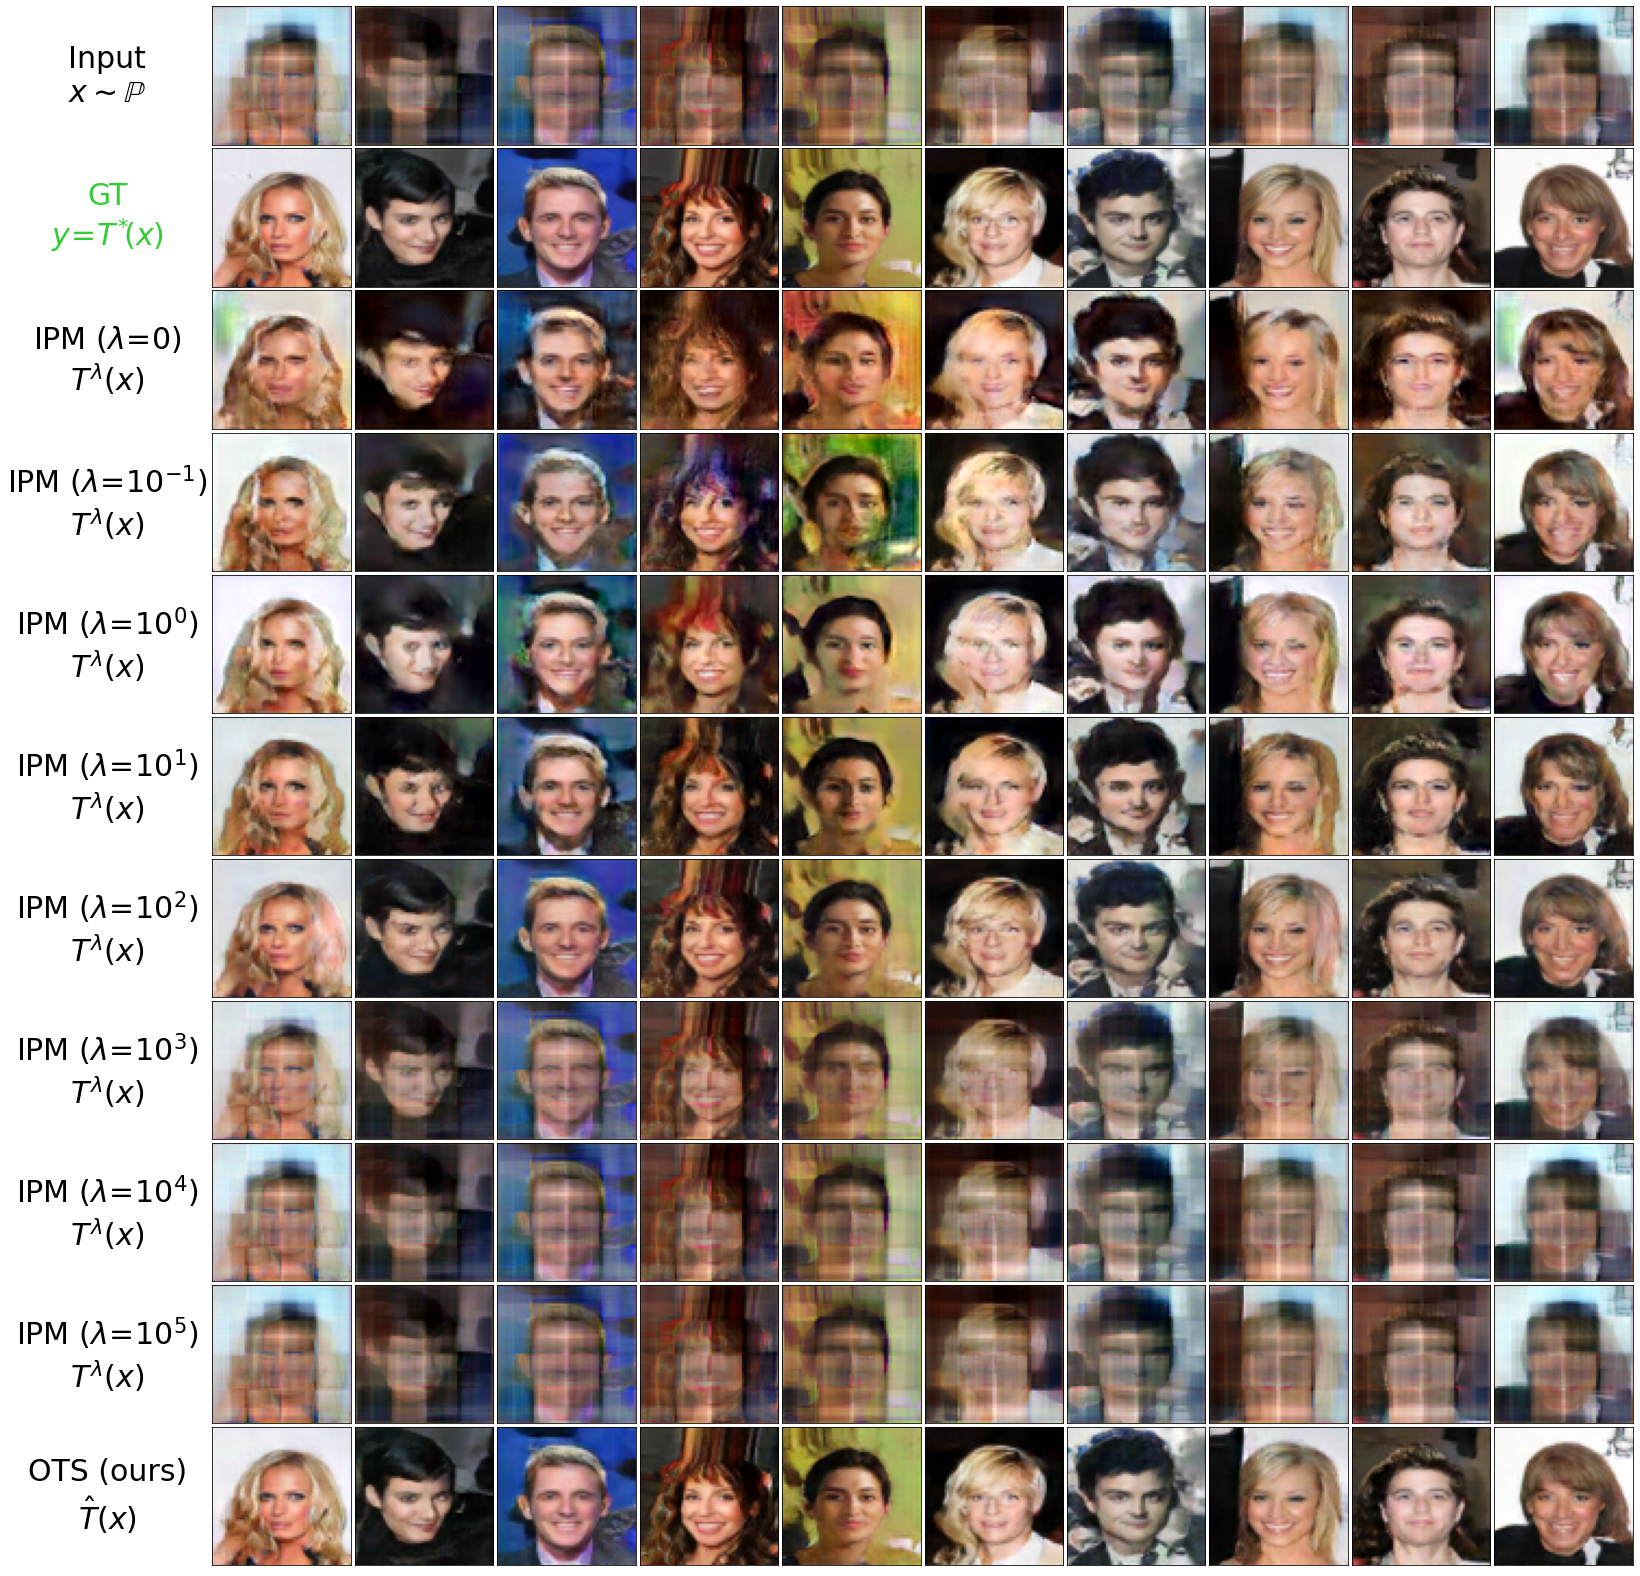

In [20]:
fig, axes = plt.subplots(3+len(LAMBDAS), len(X_fixed), figsize=(len(X_fixed)*2+3, (3+len(LAMBDAS))*2))
X_in = X_fixed.reshape(-1, 3, 64, 64).mul(.5).add(.5).clip(0, 1).cpu().detach()
Y_out = Y_fixed.reshape(-1, 3, 64, 64).mul(.5).add(.5).clip(0, 1).cpu().detach()
Ts_X_IPM = []

T.load_state_dict(torch.load(os.path.join(IN_PATH, 'T.pt')))
T = T.cuda()
freeze(T)
print('OTS: {}'.format(evaluate()))
T_X_OTS = T(X_fixed).reshape(-1, 3, 64, 64).mul(.5).add(.5).clip(0, 1).cpu().detach()

plot_params = dict(rotation='horizontal', va="center", labelpad=105, fontsize=30)

print('IPM GANs')
for j, LAMBDA in enumerate(LAMBDAS):
    T.load_state_dict(torch.load(os.path.join(IN_PATH, f'T_GP{GP}_LAMBDA{LAMBDA}.pt')))
    T = T.cuda()
    freeze(T)
    
    print('IPM {}: {}'.format(LAMBDA, evaluate()))
    Ts_X_IPM.append(T(X_fixed).reshape(-1, 3, 64, 64).mul(.5).add(.5).clip(0, 1).cpu().detach())
    power = ('$10^{' + str(int(np.log10(LAMBDA))) + '}$') if LAMBDA != 0 else '$0$'
    axes[j+2, 0].set_ylabel('IPM ' + r'($\lambda\!=\!$' + r'{}'.format(power) + ')\n' + r'$T^{\lambda}(x)$', **plot_params)

for i in range(len(X_fixed)):
    axes[0,i].imshow(X_in[i].permute(1, 2, 0))
    axes[1,i].imshow(Y_out[i].permute(1, 2, 0))
    axes[-1,i].imshow(T_X_OTS[i].permute(1, 2, 0))
    for j, LAMBDA in enumerate(LAMBDAS):
        axes[j+2,i].imshow(Ts_X_IPM[j][i].permute(1, 2, 0))
    
for i, ax in enumerate(axes.flatten()):
    ax.get_xaxis().set_visible(False)
    ax.set_yticks([])

axes[0, 0].set_ylabel('Input\n' + r'$x\sim\mathbb{P}$', **plot_params)
axes[1, 0].set_ylabel('GT\n' + r'$y\!=\!T^{*}\!(x)$', **plot_params, color='LimeGreen')
axes[-1, 0].set_ylabel('OTS (ours)\n' + r'$\hat{T}(x)$', **plot_params)

fig.tight_layout(h_pad=0.01, w_pad=0.01)
gc.collect(); torch.cuda.empty_cache()